# Forest Cover Type - explanatory data analysis

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import re
from sklearn.decomposition import PCA
from ggplot import *
from sklearn.manifold import TSNE
import umap.umap_ as umap

%matplotlib inline

Let's load the data...

In [2]:
def load_data(path):
    train_csv_path = os.path.join(path, "train.csv")
    test_csv_path = os.path.join(path, "test.csv")
    return pd.read_csv(train_csv_path), pd.read_csv(test_csv_path)

train_data, test_data = load_data("forest-cover-type-prediction")

train_data = train_data.drop(columns=["Id"])


Aggregate the categorical columns into a single *column* for making the visualisation easier.

In [3]:
def aggregate_categorical_column(df, column_name_starts_with):
    column_attributes = [attribute for attribute in df.columns.tolist() if column_name_starts_with in attribute]
    column_decoded = df[column_attributes].idxmax(1)
    column_decoded = column_decoded.apply(lambda x: int(re.match(".*_.*(\d+)", x).group(1)))
    df = df.drop(columns=column_attributes)
    df[column_name_starts_with + "_Type"] = column_decoded
    
    return df

    
train_data = aggregate_categorical_column(train_data, "Soil")
train_data = aggregate_categorical_column(train_data, "Wilderness")

train_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Type
0,2596,51,3,258,0,510,221,232,148,6279,5,9,1
1,2590,56,2,212,-6,390,220,235,151,6225,5,9,1
2,2804,139,9,268,65,3180,234,238,135,6121,2,2,1
3,2785,155,18,242,118,3090,238,238,122,6211,2,0,1
4,2595,45,2,153,-1,391,220,234,150,6172,5,9,1


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 13 columns):
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Cover_Type                            15120 non-null int64
Soil_Type                             15120 non-null int64
Wilderness_Type                       15120 non-null int64
dtypes: int64(13)
memory usage: 1.5 MB


Extract attributes by type (categorical, numerical, target).

In [5]:
attributes = train_data.columns.tolist()
categorical_attributes = ['Soil_Type', 'Wilderness_Type']
target = ['Cover_Type']
numerical_attributes = np.setdiff1d(attributes, categorical_attributes + target).tolist()

attributes, categorical_attributes, numerical_attributes, target

(['Elevation',
  'Aspect',
  'Slope',
  'Horizontal_Distance_To_Hydrology',
  'Vertical_Distance_To_Hydrology',
  'Horizontal_Distance_To_Roadways',
  'Hillshade_9am',
  'Hillshade_Noon',
  'Hillshade_3pm',
  'Horizontal_Distance_To_Fire_Points',
  'Cover_Type',
  'Soil_Type',
  'Wilderness_Type'],
 ['Soil_Type', 'Wilderness_Type'],
 ['Aspect',
  'Elevation',
  'Hillshade_3pm',
  'Hillshade_9am',
  'Hillshade_Noon',
  'Horizontal_Distance_To_Fire_Points',
  'Horizontal_Distance_To_Hydrology',
  'Horizontal_Distance_To_Roadways',
  'Slope',
  'Vertical_Distance_To_Hydrology'],
 ['Cover_Type'])

Let's plot the numerical variables distribution now...

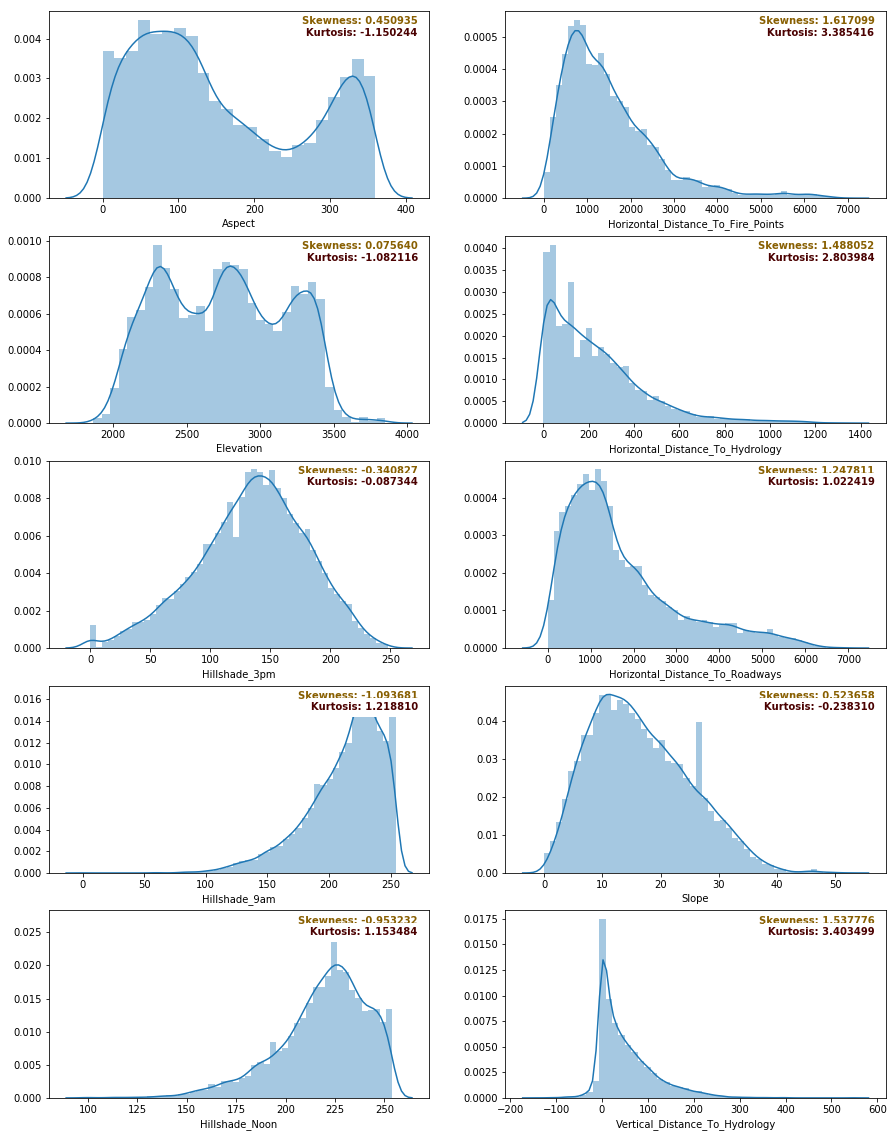

In [6]:
_, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for idx, numerical_attribute in enumerate(numerical_attributes):
    sns.distplot(train_data[numerical_attribute], ax=ax[idx % 5][idx // 5])
    ax[idx % 5][idx // 5].text(x=0.97, y=0.97, transform=ax[idx % 5][idx // 5].transAxes, s="Skewness: %f" % train_data[numerical_attribute].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax[idx % 5][idx // 5].text(x=0.97, y=0.91, transform=ax[idx % 5][idx // 5].transAxes, s="Kurtosis: %f" % train_data[numerical_attribute].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')

Now let's plot insights for the categorical variables.

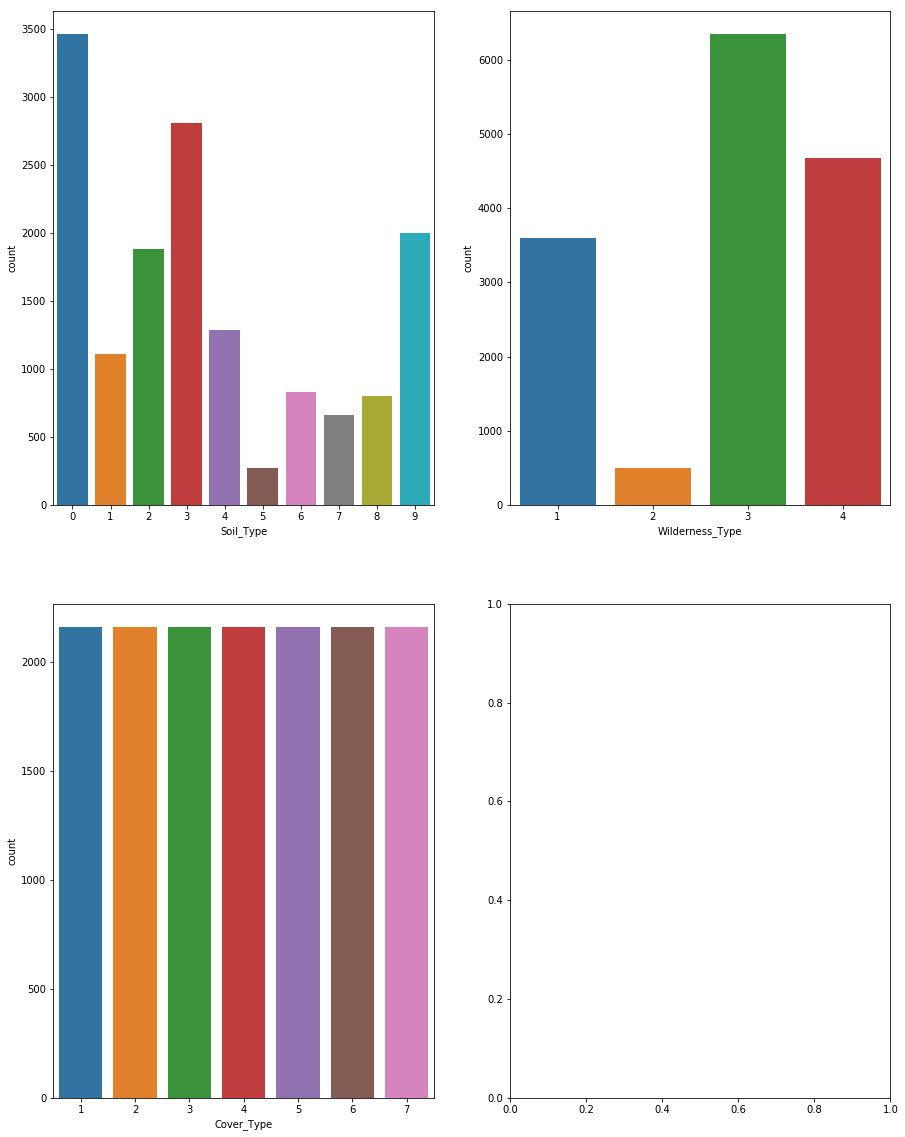

In [7]:
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 20))

for idx, categorical_attribute in enumerate(categorical_attributes + target):
    sns.countplot(x=categorical_attribute, data=train_data, ax=ax[idx // 2][idx % 2])

Boxplots:

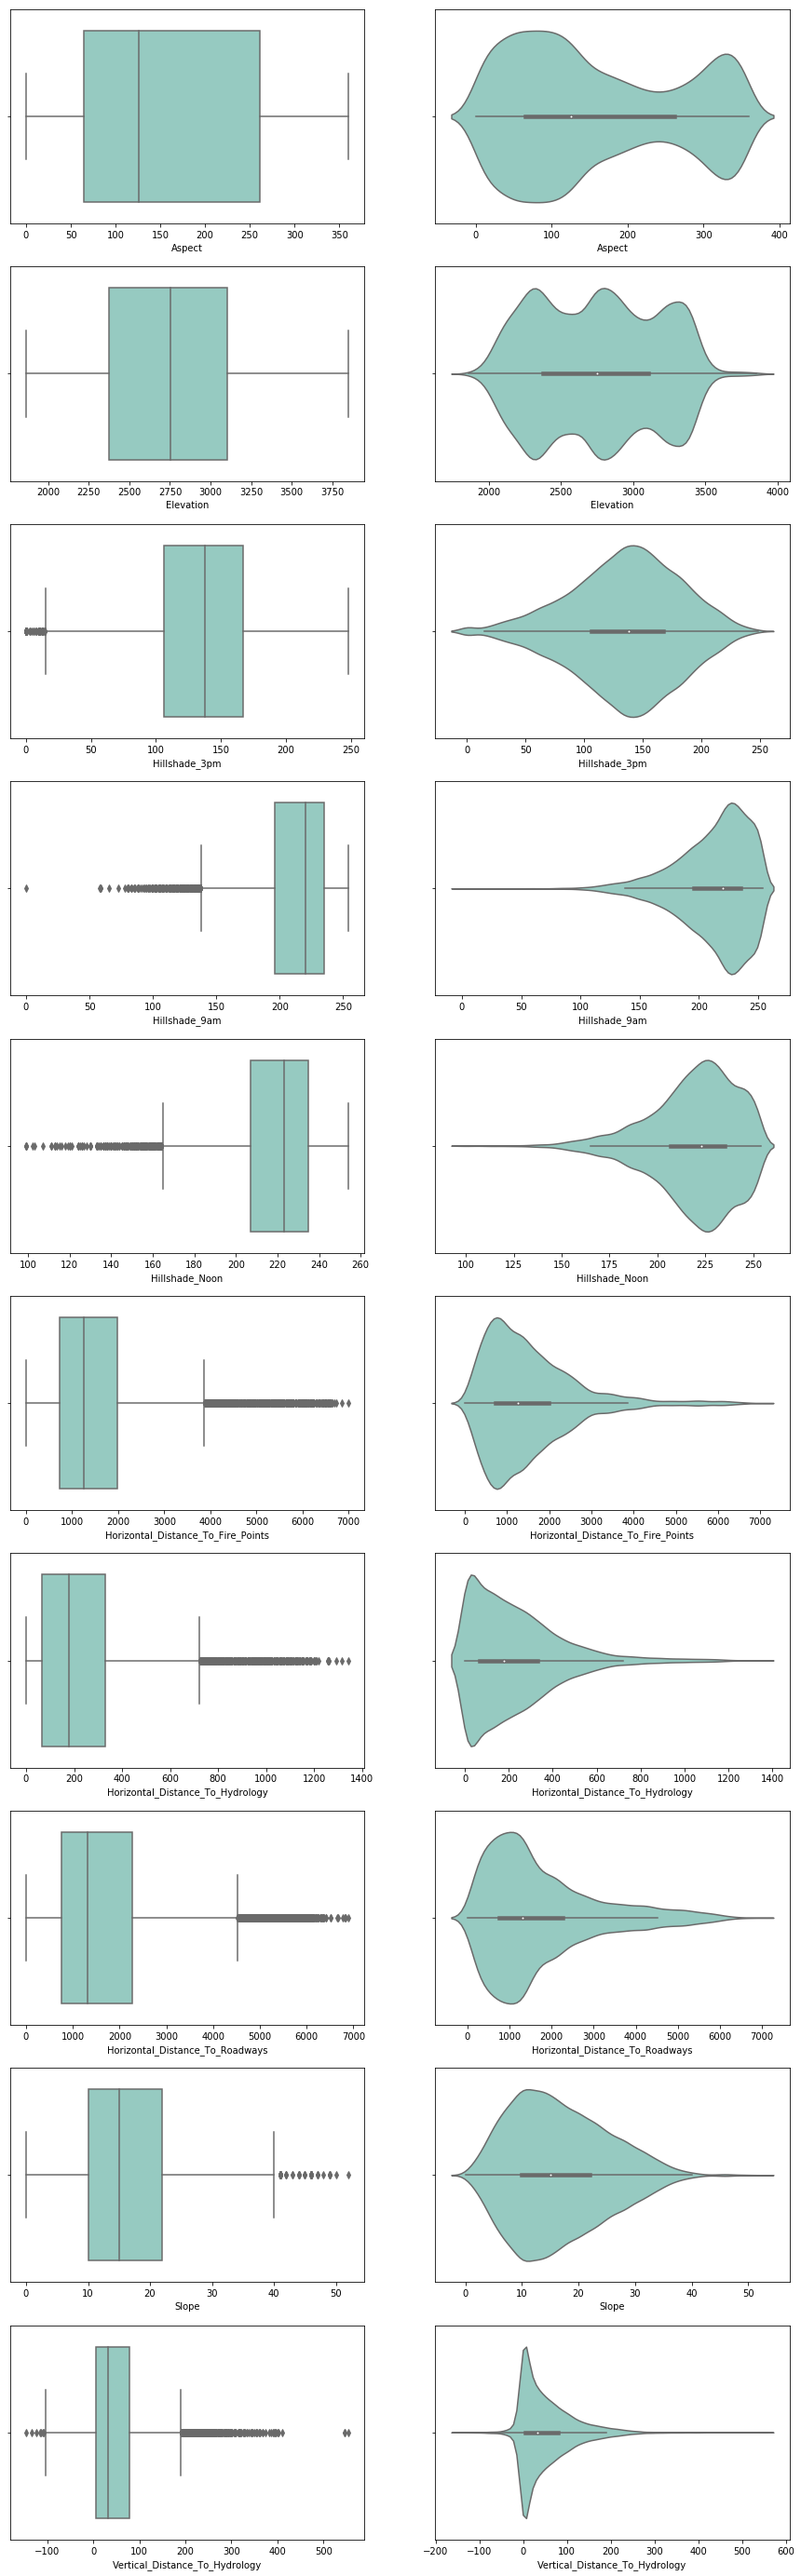

In [8]:
_, ax = plt.subplots(nrows=10, ncols=2, figsize=(15, 50))

for idx, numerical_attribute in enumerate(numerical_attributes):
    sns.boxplot(x=numerical_attribute,
                 data=train_data, palette="Set3", ax=ax[idx][0])
    sns.violinplot(x=numerical_attribute,
                 data=train_data, color=".8", ax=ax[idx][1], palette="Set3")
    


Correlation matrix for all the attributes

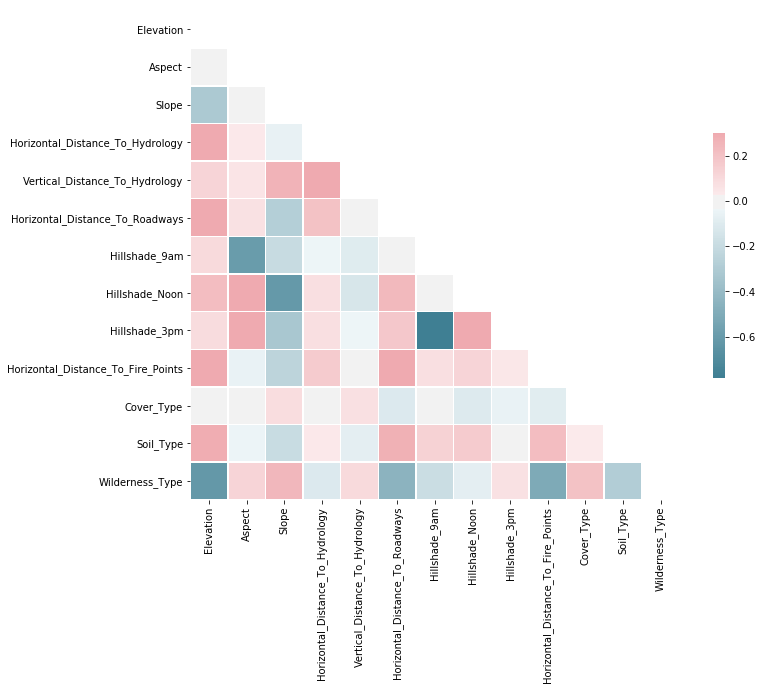

In [9]:
correlation_matrix = train_data.corr()

mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

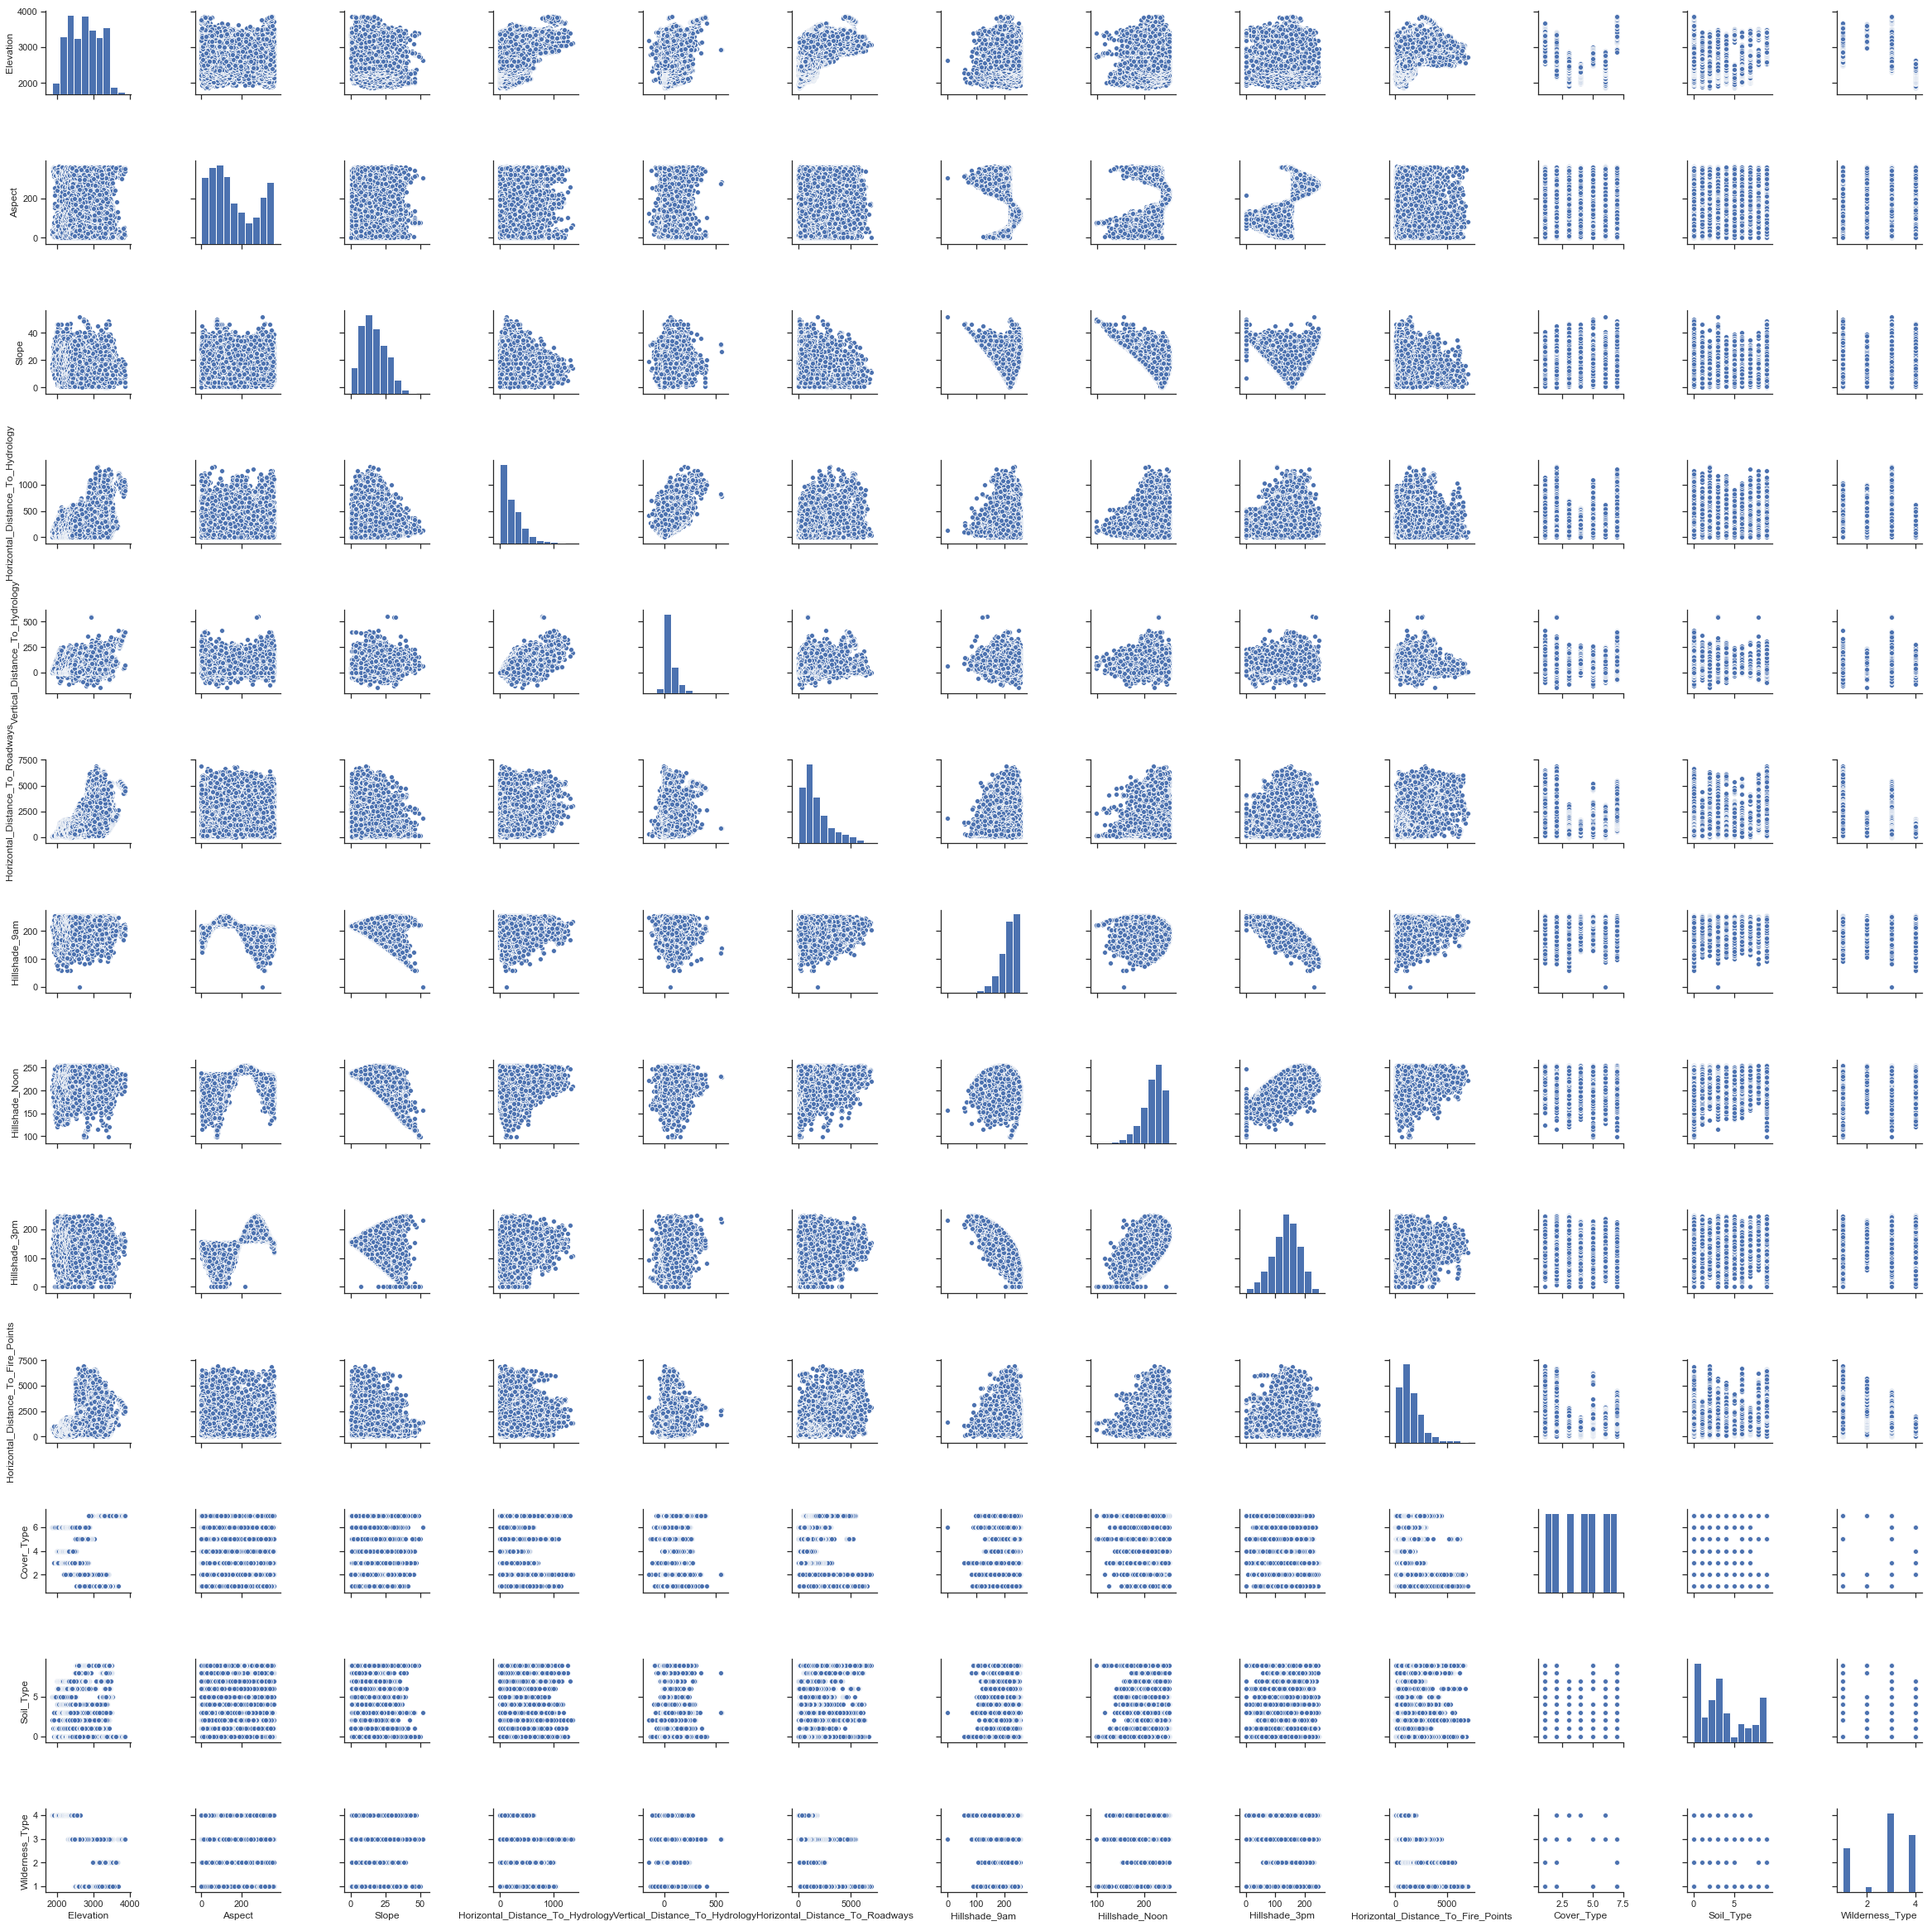

In [10]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
sns.pairplot(train_data)

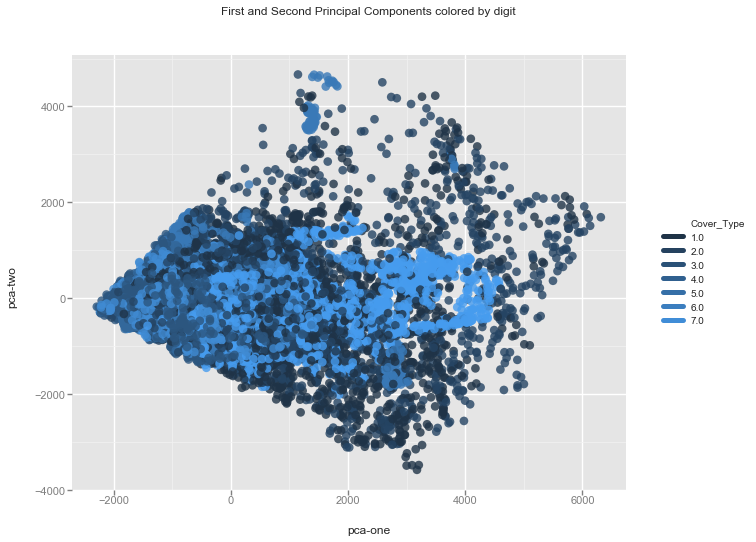

<ggplot: (-9223372036558363283)>

In [32]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_data[numerical_attributes + categorical_attributes])

train_data['pca-one'] = pca_result[:,0]
train_data['pca-two'] = pca_result[:,1] 

'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)

chart = ggplot(train_data, aes(x='pca-one', y='pca-two', color=target[0]) ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15120 samples in 0.065s...
[t-SNE] Computed neighbors for 15120 samples in 0.445s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15120
[t-SNE] Computed conditional probabilities for sample 2000 / 15120
[t-SNE] Computed conditional probabilities for sample 3000 / 15120
[t-SNE] Computed conditional probabilities for sample 4000 / 15120
[t-SNE] Computed conditional probabilities for sample 5000 / 15120
[t-SNE] Computed conditional probabilities for sample 6000 / 15120
[t-SNE] Computed conditional probabilities for sample 7000 / 15120
[t-SNE] Computed conditional probabilities for sample 8000 / 15120
[t-SNE] Computed conditional probabilities for sample 9000 / 15120
[t-SNE] Computed conditional probabilities for sample 10000 / 15120
[t-SNE] Computed conditional probabilities for sample 11000 / 15120
[t-SNE] Computed conditional probabilities for sample 12000 / 15120
[t-SNE] Computed conditional probabilities for sa

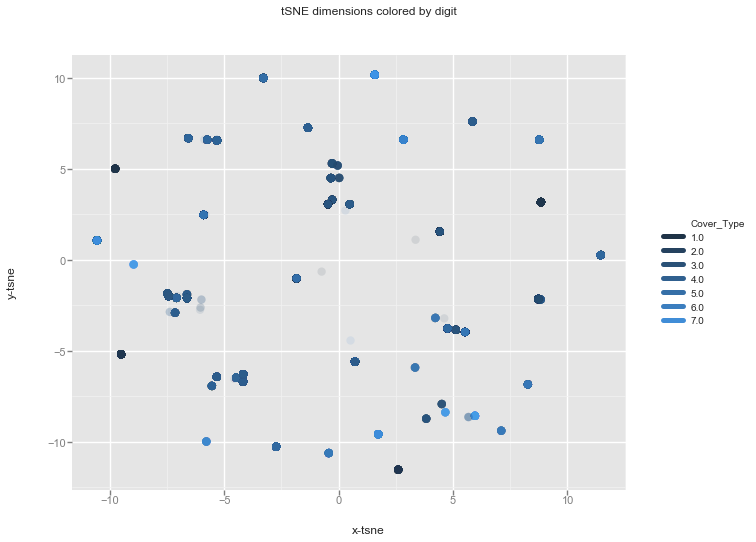

<ggplot: (310923731)>

In [69]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_data[categorical_attributes])

df_tsne = train_data.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color=target[0])) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

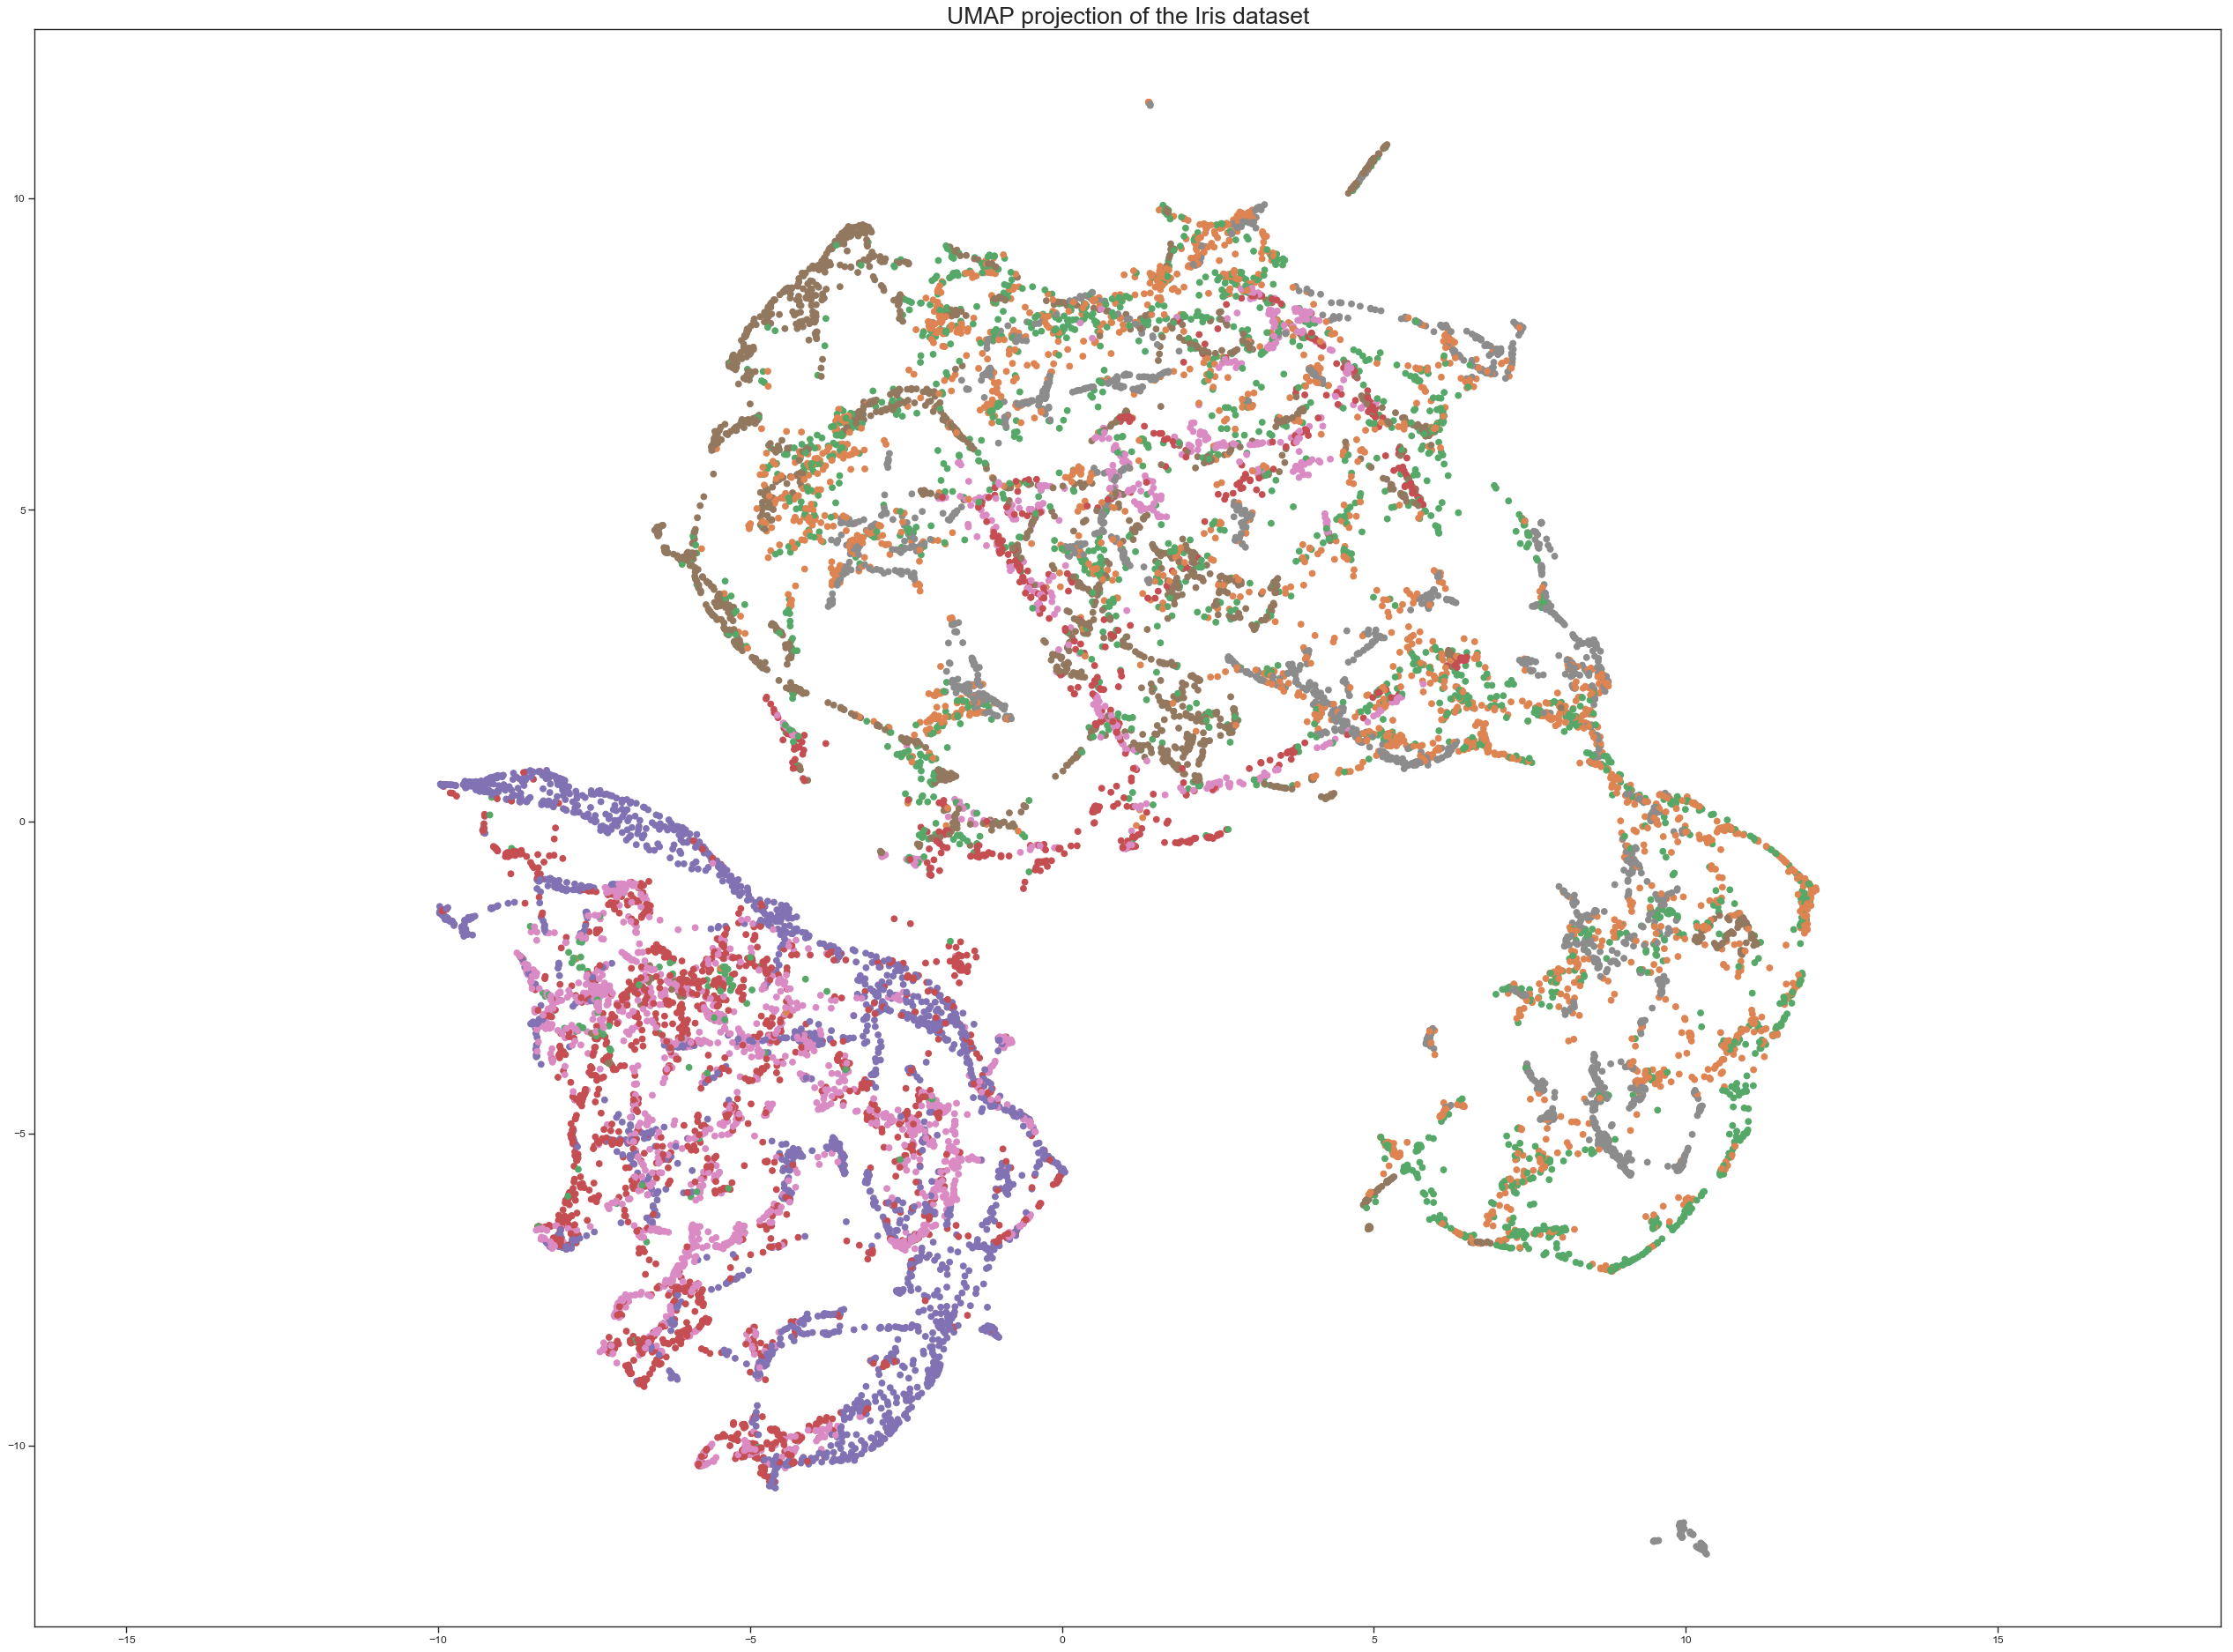

In [67]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(train_data[numerical_attributes + categorical_attributes])

plt.figure(figsize=(40, 30), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in train_data[target[0]]])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Iris dataset', fontsize=24);